In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
from sklearn.metrics import classification_report
import time 

import os

directory = 'data/train'
contents = os.listdir(directory)
num_of_dirs = len([name for name in contents if os.path.isdir(os.path.join(directory, name))])

print("Contents of the directory:")
for item in contents:
    print(item)

print(f"\nNumber of directories: {num_of_dirs}")



Contents of the directory:
images
labels

Number of directories: 2


In [2]:
# Load images from the directory

from PIL import Image
import os

directory_path = 'data/train'

file_names = os.listdir(directory_path)

images = []
for file_name in file_names:
    if file_name.endswith('.png') or file_name.endswith('.jpg') or file_name.endswith('.jpeg'):
        image_path = os.path.join(directory_path, file_name)
        image = Image.open(image_path)
        images.append(image)

if images:
    images[0].show()
else:
    print("No images found in the directory.")

No images found in the directory.


In [3]:
# Define parameters
batch_size = 128
num_epochs = 10
image_size = (139, 139)
num_classes = 2


In [4]:
# Load the model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))

for layer in base_model.layers:
    layer.trainable = False


In [5]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
class_outputs = Dense(num_classes, activation='softmax')(x)


In [7]:
# Model Creation

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = Model(inputs=base_model.input, outputs=class_outputs)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(
    'data/train',  
    target_size=(139, 139),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_dataset = val_datagen.flow_from_directory(
    'data/valid',
    target_size=(139, 139),
    batch_size=batch_size,
    class_mode='categorical'
)

def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif 10 <= epoch < 20:
        return 0.0001
    else:
        return 0.00001

lr_schedule = LearningRateScheduler(lr_scheduler)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[lr_schedule, early_stop, checkpoint, reduce_lr]
)

model.save('weed.h5')


Found 2469 images belonging to 2 classes.
Found 235 images belonging to 2 classes.
Epoch 1/10


c:\Users\Dinak\.conda\envs\dev\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5347 - loss: 1.1285
Epoch 1: val_accuracy improved from -inf to 0.99574, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5359 - loss: 1.1224 - val_accuracy: 0.9957 - val_loss: 0.1786 - learning_rate: 0.0010
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6413 - loss: 0.7208
Epoch 2: val_accuracy did not improve from 0.99574
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6435 - loss: 0.7172 - val_accuracy: 0.9787 - val_loss: 0.2329 - learning_rate: 0.0010
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7895 - loss: 0.4617
Epoch 3: val_accuracy did not improve from 0.99574
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7907 - loss: 0.4600 - val_accuracy: 0.9872 - val_loss: 0.2725 - learning_rate: 0.0010
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8821 - loss: 0.3369
Epoch 4: val_accuracy improved from 0.99574 to 1.00000, saving model to be

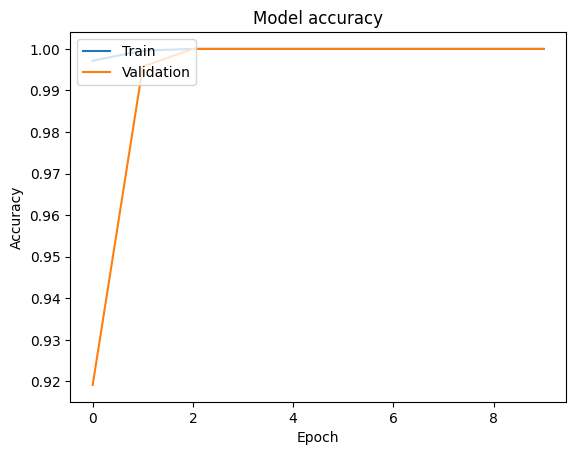

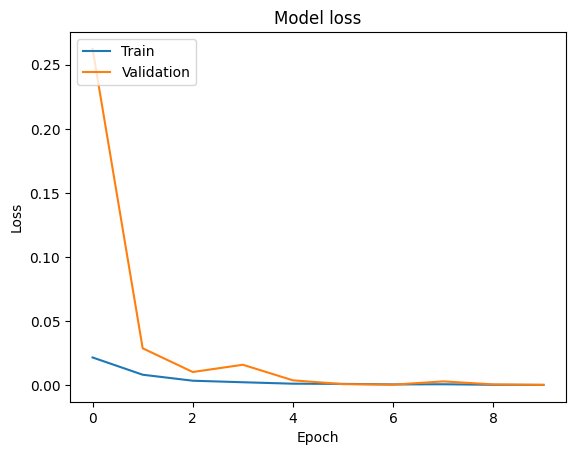

In [33]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_metrics(history)

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt 

model = tf.keras.models.load_model('best_model.h5')

img_path = 'data/test/ridderzuring_3126_jpg.rf.8980b3ae3ec4ecd023aab5bc54c26089.jpg'
img = image.load_img(img_path, target_size=(139, 139))

In [47]:
img_path = 'data/test/image.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(139, 139))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.image.resize(img_array, (139, 139))
img_array = tf.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [1]:
# Overlay the heatmap on the original image

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

last_conv_layer = model.get_layer('mixed10')  
heatmap_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output[0]])

with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(img_array)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)

heatmap_resized = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

img_array_uint8 = (img_array[0].numpy() * 255).astype(np.uint8)
heatmap_resized_uint8 = (heatmap_resized * 255).astype(np.uint8)  # Adjust the range of heatmap values

heatmap_resized_uint8 = cv2.applyColorMap(heatmap_resized_uint8, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_array_uint8, 0.6, heatmap_resized_uint8, 0.4, 0)



NameError: name 'model' is not defined

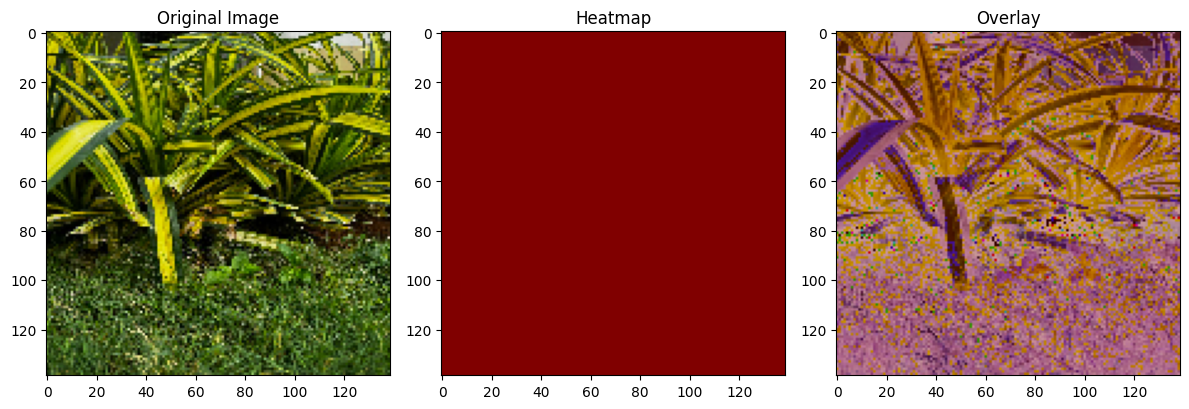

In [49]:
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(heatmap_resized_uint8)
plt.title('Heatmap')

plt.subplot(133)
plt.imshow(superimposed_img)
plt.title('Overlay')

plt.tight_layout()
plt.show()